**Example 1 - Lorenz equations**

This notebook applies **Appendix A Transformation of probability density** of *Craske J. et al. 2024* to compute the time evolution of joint probability density $f_\mathbf{Y}$ of the vertical velocity $Y^1_t$ and buoyancy field $Y^2_t$ 

\begin{align}
  Y_{1} &=\varphi_{t}^{1}(X_{1},X_{2}):=\frac{\sqrt{2}}{\pi}\left(k^{2}+\pi^{2}\right)a_{1}(t)\mathrm{cos}(kX_{1})\mathrm{sin}(\pi X_{2}), \\
  Y_{2} &=\varphi_{t}^{2}(X_{1},X_{2}):=\frac{\sqrt{2}}{\pi r}a_{2}(t)\mathrm{cos}(kX_{1})\mathrm{sin}(\pi X_{2})-\frac{1}{\pi r}a_{3}(t)\mathrm{sin}(2\pi X_{2}),
\end{align}

on a horizontally periodic domain $\mathcal{X} := [0,2\pi/k)\times [0,1]\ni \mathbf{X}:=(X_{1},X_{2})$, which evolve according to the Lorenz (1963) model 

\begin{align}
  \frac{da_{1}}{dt} &= s(a_{2}-a_{1}),\\
  \frac{da_{2}}{dt} &= ra_{1}-a_{2}-a_{1}a_{3},\\
  \frac{da_{3}}{dt} &= a_{1}a_{2}-ba_{3},
\end{align}
where $b:=4\pi^{2}(k^{2}+\pi^{2})^{-1}$ characterises the aspect ratio of the domain, $s$ is the Prandtl number and $r$ is a renormalised Rayleigh number.

To compute the time-evolution $f_{\mathbf{Y}}$ we first define the fields $Y^1_t, Y^2_t$ and the Lorenz equations below along with helper functions for the coefficients

In [21]:
import numpy as np

def calc_coeffs(r=28,b=8/3):
    k = np.sqrt( (4-b)*np.pi**2/b )
    c0 = np.sqrt(2)/np.pi*(k**2+np.pi**2)
    c1 = np.sqrt(2)/np.pi/r
    c2 = 2/r/np.pi
    return [c0, c1, c2]

def wavenumber(b=8/3):
    """wavenumber k for a given parameter b"""
    return np.sqrt( (4-b)*np.pi**2/b )

def field(X, a, s=10,r=28,b=8/3):
    """Return the vertical velocity and buoyancy field for a given state a(t)"""
    k = wavenumber(b)
    c = calc_coeffs(r=r,b=b)

    # Vertical velocity
    Y0 = c[0]*a[0]*np.cos(k*X[0])*np.sin(np.pi*X[1])

    # Buoyancy field
    Y1 = c[1]*a[1]*np.cos(k*X[0])*np.sin(np.pi*X[1])-c[2]*a[2]*np.sin(2*np.pi*X[1])/2
    return [Y0, Y1]

def tangent(t, a, s=10, r=28, b=8/3):
    """Phase space velocity of the Lorenz equations."""
    da = [0]*3
    da[0] = s * (a[1]-a[0])
    da[1] = a[0] * (r - a[2]) - a[1]
    da[2] = a[0] * a[1] - b * a[2]
    return da

Note that the default parameters for all functions are set to $s = 10, r = 28, b = 8/3$ but these can be modified by the user. To generate the coefficients $a = [a_1(t), a_2(t), a_3(t)]$ as a function of time we simulate the Lorenz system using scipy.

In [93]:
from scipy.integrate import solve_ivp

nt = 5000  # total
tend = 100  # spacing between saved snapshots
dt = tend/nt
t = np.linspace(0,tend,nt+1)
sol = solve_ivp(tangent, np.array([0,tend]), np.array([1.0,1.0,8.0]), t_eval=t)
a = sol.y.T

Below we plot a snapshot of the field in terms of the vertical velocity $Y^1_t$ shown as white contours and $Y^2_t$ shown as in terms of a Blue-Red colourmap. 

In [94]:
# Define X-domain and Y1, Y2 fields
k = wavenumber()
x = np.linspace(0, 2*np.pi/k,400)
z = np.linspace(0, 1,400)
[X,Z] = np.meshgrid(x,z, indexing='ij')

# Pick a time index to display fields
i = 2800

# Evaluate the fields Y1,Y2
Y1,Y2 = field([X,Z], a[i,:])

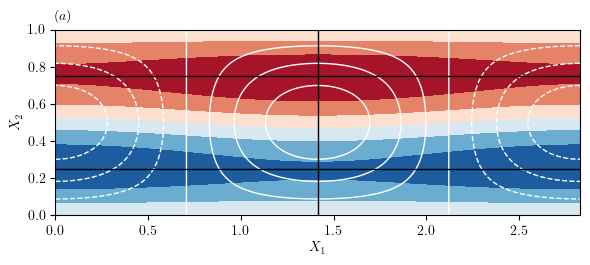

In [95]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

plt.figure(figsize=(6,5))
plt.contourf(X,Z,Y2, cmap='RdBu_r') # plot the buoyancy field
plt.gca().set_aspect('equal', adjustable='box')
plt.contour(X,Z,Y1,10, colors='w',linewidths=1.0) # plot the vertical velocity
plt.plot([np.pi/k,np.pi/k],[0,1],'k-',lw=1.0)
plt.plot([0,2*np.pi/k],[0.25,0.25],'k-',lw=1.0)
plt.plot([0,2*np.pi/k],[0.75,0.75],'k-',lw=1.0)
plt.xlabel('$X_{1}$')
plt.ylabel('$X_{2}$')
plt.annotate('$(a)$', xy=(0.0, 1.05), xycoords='axes fraction')
plt.tight_layout()
plt.show()

Computing the joint pdf relies on calculating the determininat $J$ of the jacobian $\partial \mathbf{Y}^{-1} / \partial \mathbf{y}$, where $\mathbf{Y}^{-1}$ is the inverse of $\mathbf{Y}(\mathbf{X})$. For this to be possible $\mathbf{Y}$ must be invertible, but as our function has stationary points, this is not possible over the entire domain. In the previous plot we have demarcated (in solid black lines) the six subdomains defined by the stationary points of $\mathbf{Y}$, over which the density can be calculated. In our calculation we can therefore first compute the density within each subdomain, where $J(\mathbf{y})$ is well defined, by evaluating
\begin{equation}
f_{\mathbf{Y}|D}(\mathbf{y}) = \frac{1}{\mu^d(D) |J(\mathbf{y})|},
\end{equation}
where $\mu^d(D)$ denotes the size of subdomain $D$. By summing over the subdomains which partion the domain $\mathcal{X}$, the global density
\begin{equation}
f_{\mathbf{Y}}(\mathbf{y}) = \sum f_{\mathbf{Y}|D}(\mathbf{y}) \frac{\mu^d(D)}{\mu^d(\mathcal{X})},
\end{equation}
can then be recovered.

To compute the jacobian matrix $\partial \mathbf{Y}^{-1}/ \partial \mathbf{X}$ we first let $S = \sin(\pi X_2), C = \cos(k X_1)$ and rewrite the fields as
\begin{align}
  y_1 &= c_1 a_{1}(t) C S, \\
  y_2 &= c_2 a_{2}(t) C S - c_3 a_{3}(t) \sqrt{R},
\end{align}
where $R = S^2(1 - S^2)$. Substituting the first equation into the second we obtain
\begin{equation}
R = \frac{1}{(c_3 a_3)^2} \left( \frac{c_2 a_2}{c_1 a_1} y_1  - y_2\right)^2.
\end{equation}

By rewriting these equations in terms of $y_1,y_2$ as
\begin{align}
  S &= \sqrt{ \frac{1 + \text{sign} \sqrt{1 - 4R} }{2}}, \\
  C &= y_1/c_1 a_{1}(t) S,
\end{align}
where sign can be $\pm$, and then using the fact that $C,S$ have a well defined inverse, we obtain $\mathbf{Y}^{-1}$ as
\begin{align}
X_1(y_1, y_2) &= \frac{-1}{k}\cos^{-1}(C), \\ 
X_2(y_1, y_2) &= \frac{1}{\pi}\sin^{-1}(S).
\end{align}

To compute the Jacobian we can then avail of the fact that
\begin{align}
\frac{d X_1}{d C} &= \frac{-1}{k} \frac{1}{\sqrt{1-C^2}}, \\ 
\frac{d X_2}{d S} &= \frac{1}{\pi} \frac{1}{\sqrt{1-S^2}}.
\end{align}
and then by applying the chain-rule to compute $\frac{\partial C}{\partial y_1}, \frac{\partial C}{\partial y_2}$ and $\frac{\partial S}{\partial y_1}, \frac{\partial S}{\partial y_2}$ we can determine the terms of the Jacobian matrix. This calculation is implemented in the function below which computes
\begin{equation}
J = \frac{\partial X_1}{\partial y_1} \frac{\partial X_2}{\partial y_2} - \frac{\partial X_2}{\partial y_1} \frac{\partial X_1}{\partial y_2},
\end{equation}
over the submdomain indicated by the parameter sign.

In [96]:
def jacobian(y, a, sign, r=28, b=8/3):
    """Return the jacobian field for a given state a(t) in terms of y"""
    # Due to python indexing from zero we use y1 = y[0] & y2 = y[1]

    k = wavenumber(b)
    c = calc_coeffs(r=r,b=b)

    # Evaluate R = S^2(1 - S^2)
    R = 1/(c[2]*a[2])**2 * (c[1]*a[1]/(c[0]*a[0])*y[0] - y[1])**2
    
    # Perform the inversion
    S = np.sqrt( (1 + sign*np.sqrt(1-4*R))/2)
    C = y[0] / (c[0]*a[0]) / S

    # Compute the total derivative
    dX2dS = 1/np.pi * 1 / np.sqrt(1 - S**2)
    dX1dC = -1/k * 1 / np.sqrt(1 - C**2)

    # Compute the  partial derivatives to determine the jacobian
    dSdR = -sign*1/2 * S**(-1) * (1-4*R)**(-1/2)
    dCdR = -(y[0] / (c[0]*a[0]) /S**2) * dSdR

    dRdy1  =  2*c[1]*a[1]/(c[0]*a[0])/(c[2]*a[2])**2 * (c[1]*a[1]/(c[0]*a[0])*y[0] - y[1])
    dRdy2  = -2/(c[2]*a[2])**2 * (c[1]*a[1]/(c[0]*a[0])*y[0] - y[1])

    # Evaluate the terms of the jacobian
    dX1dy1 = dX1dC * (1/(c[0]*a[0])/S + dCdR * dRdy1)
    dX1dy2 = dX1dC * dCdR * dRdy2
    dX2dy1 = dX2dS * dSdR * dRdy1
    dX2dy2 = dX2dS * dSdR * dRdy2

    return dX1dy1*dX2dy2 - dX2dy1*dX1dy2

Due to the symmetric form of $\mathbf{Y}$ the determinant $J(\mathbf{y})$ only takes two forms over the six subdomains considered. For this reason it suffices to conisder the regions
\begin{align}
D1 &:=(0,\pi/k] \times [0,1/4), \\ 
D2 &:=(0,\pi/k] \times (1/4, 1/2],
\end{align}
and then to avail of symmetries passed through the *sign* term in the equation for $S$. Below we first evaluate the local density $f_Y|D$ and then using this obtain the global density by summing over the sub-domains.

In [97]:
olderr = np.seterr(all='ignore')  # Set error handling to known state.

def local_density(y, a, subdomain, r=28, b=8/3):
    """Compute the local density f_Y|D by calculating the jacobian."""    

    # Distinguish between the two subdomains over which Y is invertible
    # and determine their size mu(D) 
    if (subdomain == 'D1'):
        sign = -1
        mu_D = (np.pi/k)*(1/4)
    else:
        sign = 1
        mu_D = (np.pi/k)*(1/4)

    # Evaluate the Jacobian
    J = jacobian(y, a, sign, r, b)

    # Compute its absolute value
    J = np.abs(J)

    # Eliminate nan's
    J[np.isnan(J)] = 0

    # Divide by the subdomain size
    f_YD = J/mu_D

    return f_YD

def density(y, a, r=28, b=8/3):
    """Calculate global density in terms of Y by combining local-density for D1 and D2"""
    
    f_YD1 = local_density(y, a, 'D1', r, b)
    f_YD2 = local_density(y, a, 'D2', r, b)

    return f_YD1 + f_YD2

Below we plot the global density corresponding to the previously plotted field, to which we have also outlined the algebraic curve defining the singular points of the distribution

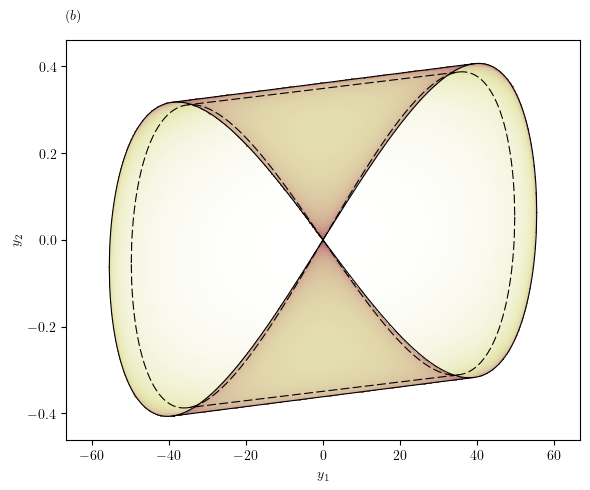

In [98]:
def plot_algebraic_curve(a, n=500, r=28, ocol='k', icol='k', **kwargs):
    """Plot singularities of probability distribution in phase space."""
    c = calc_coeffs(r)

    s = np.linspace(-1,1,n)
    Ws0 = c[0]/np.sqrt(2)*a[0]*s

    s = np.linspace(0,1,n)
    Ws1 = c[0]*a[0]*s

    plt.plot(Ws0, c[1]/c[0]*a[1]/a[0]*Ws0 + c[2]/2*a[2],color=ocol,**kwargs)
    plt.plot(Ws0, c[1]/c[0]*a[1]/a[0]*Ws0 - c[2]/2*a[2],color=ocol,**kwargs)
    plt.plot(Ws1, c[1]/c[0]*a[1]/a[0]*Ws1 - c[2]*a[2]*s*(1-s**2)**(1/2),color=icol,**kwargs)
    plt.plot(Ws1, c[1]/c[0]*a[1]/a[0]*Ws1 + c[2]*a[2]*s*(1-s**2)**(1/2),color=icol,**kwargs)
    plt.plot(-Ws1, -c[1]/c[0]*a[1]/a[0]*Ws1 - c[2]*a[2]*s*(1-s**2)**(1/2),color=icol,**kwargs)
    plt.plot(-Ws1, -c[1]/c[0]*a[1]/a[0]*Ws1 + c[2]*a[2]*s*(1-s**2)**(1/2),color=icol,**kwargs)

def y_range(a, s=10,r=28,b=8/3):
    """Determin the range of Y(X) for a given state a(t)"""
    
    n1 = 500
    scale = 1.2

    c = calc_coeffs(r=r,b=b)

    # Set bounds for the domain of PDF f
    y1_min = -np.sign(a[0])*c[0]*a[0]
    y1_max =  np.sign(a[0])*c[0]*a[0]
    if a[1] > 0:
        y2_min = -c[1]*a[1]/np.sqrt(2) - c[2]*a[2]
        y2_max = c[1]*a[1]/np.sqrt(2) + c[2]*a[2]
    else:
        y2_min = c[1]*a[1]/np.sqrt(2) - c[2]*a[2]
        y2_max = -c[1]*a[1]/np.sqrt(2) + c[2]*a[2]
    y2_max *=.5
    y2_min *=.5

    y1_ = np.linspace(scale*y1_min, scale*y1_max, n1)
    y2_ = np.linspace(scale*y2_min, scale*y2_max, n1)

    # Y-domain for PDF
    [y1,y2] = np.meshgrid(y1_,y2_, indexing='ij')

    return y1,y2

# Pick a time index to display fields
i = 2800 

# Determine the function's range
y1,y2 = y_range(a[i,:])

# Calculate the joint density
f_Y = density([y1, y2], a[i,:], r=28, b=8/3)

# Plot the density
plt.figure(figsize=(6,5))
plt.pcolor(y1, y2, f_Y, cmap='pink_r', norm='log')
plot_algebraic_curve(a[i,:], lw=0.8)  # Plot the outline of the density in terms of it's singularities
plot_algebraic_curve(a[i+1,:], linestyle='--', lw=0.8, dashes=(8,3) )  # Repeat 200 time-steps later 
plt.xlabel('$y_{1}$')
plt.ylabel('$y_{2}$')
plt.annotate('$(b)$', xy=(0.0, 1.05), xycoords='axes fraction')
plt.tight_layout()
plt.show()